In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
data = read_data()
nodes = {"pi"+str(i+2):i for i in range(4)}

## Visualising Data

In [4]:
import matplotlib.pyplot as plt

def plot_experiment(node_data):
    plt.rcParams["figure.figsize"] = (8,5)
    
    a,b,c,d = node_data
    
    plt.scatter(a.humidity, a.temperature, marker= ".", label="pi2", alpha =0.5)
    plt.scatter(b.humidity, b.temperature, marker = "v", label="pi3", alpha=0.5)
    plt.scatter(c.humidity, c.temperature, marker = "^", label="pi4", alpha=0.5)
    plt.scatter(d.humidity, d.temperature, marker = "*", label="pi5", alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel="Humidity")
    plt.ylabel(ylabel="Temperature")
    plt.show()

def plot_experiments():
    for i in range(1,4):
        node_data = get_node_data(data, experiment =i)
        plot_experiment(node_data)

## Outliers removed with OCSVM

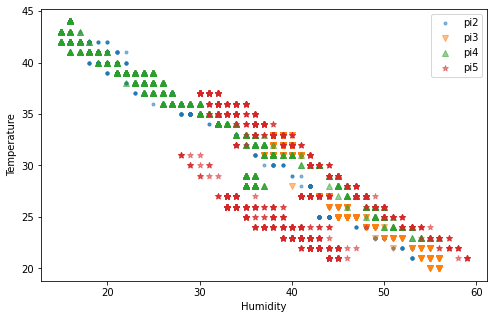

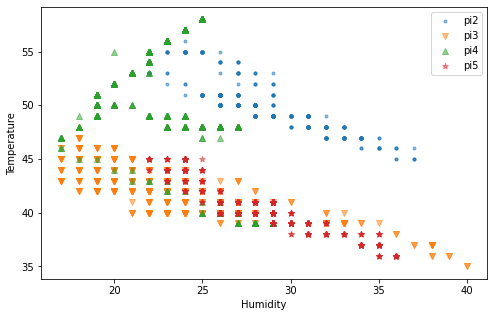

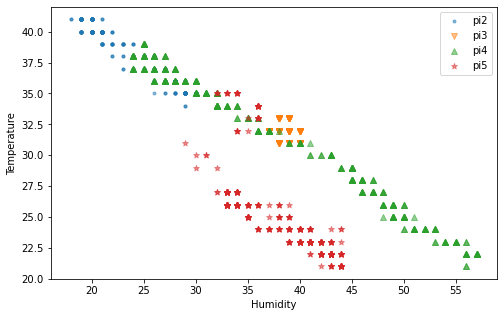

In [5]:
plot_experiments()

### When outliers are not removed with OCSVM

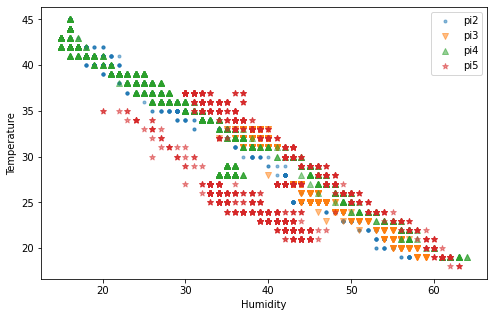

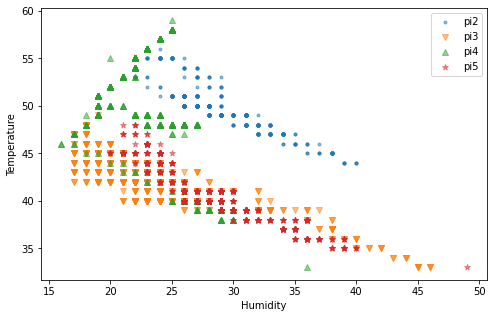

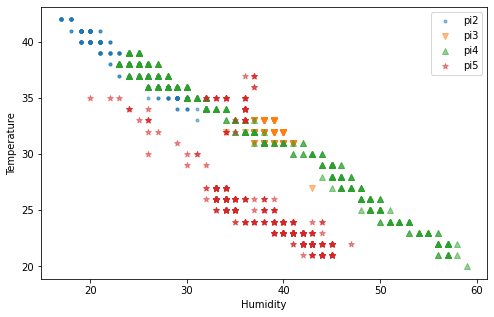

In [5]:
plot_experiments()

## Similarity MMD

In [16]:
from maximum_mean_discrepancy import MMD, get_tensor_samples
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASD_MMD
from prettytable import PrettyTable
    
def print_mmd(x,y, kernel, kernel_bandwidth):  
    result = MMD(x,y, kernel, kernel_bandwidth)
    print(f"mmd result of X and Y is {result.item()}")

def bandwidth_experiment(samples, similar_sets, dissimilar_sets, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASD_MMD(samples, similar_sets, dissimilar_sets, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [26]:
m = 200
samples = get_tensor_samples(data, experiment=1, sample_size=m)

In [6]:
similar_sets = ["pi2","pi4"]
dissimilar_sets = ["pi3","pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(2.0339) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(32.9921) |
| ('pi3', 'pi4') | tensor(32.4272) |
| ('pi5', 'pi2') | tensor(27.7680) |
| ('pi5', 'pi4') | tensor(27.0771) |
| ('pi3', 'pi5') |  tensor(3.7611) |
+----------------+-----------------+

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(6.1016) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(98.9763) |
| ('pi3', 'pi4') | tensor(97.2816) |
| ('pi5', 'pi2') | tensor(83.3041) |
| ('pi5', 'pi4') | tensor(81.2314) |
| ('pi3', 'pi5') | tensor(11.2832) |
+

In [7]:
similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(3.7611) |
| ('pi2', 'pi4') | tensor(2.0339) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(32.9921) |
| ('pi2', 'pi5') | tensor(27.7680) |
| ('pi4', 'pi3') | tensor(32.4272) |
| ('pi4', 'pi5') | tensor(27.0771) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi5') | tensor(11.2832) |
| ('pi2', 'pi4') |  tensor(6.1016) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(98.9764) |
| ('pi2', 'pi5') | tensor(83.3041) |
| ('pi4', 'pi3') | tensor(97.2816) |
| ('pi4', 'pi5') | tensor(81.2314)

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [35]:
samples = get_tensor_samples(data, experiment=3, sample_size=m)

In [36]:
similar_sets = ["pi2", "pi4"]
dissimilar_sets = ["pi3", "pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | tensor(30.2673) |
| ('pi3', 'pi2') | tensor(28.2074) |
| ('pi3', 'pi4') |  tensor(2.6067) |
| ('pi5', 'pi4') |  tensor(5.7325) |
| ('pi3', 'pi5') |  tensor(7.0070) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | tensor(39.8775) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | tensor(90.8019) |
| ('pi3', 'pi2') | tensor(84.6223) |
| ('pi3', 'pi4') |  tensor(7.8203) |
| ('pi5', 'pi4') | tensor(17.1976) |
| ('pi3', 'pi5') | tensor(21.0213) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi5', 'pi2') | tensor

In [11]:
similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(31.5474) |
| ('pi2', 'pi4') | tensor(27.8966) |
| ('pi3', 'pi4') |  tensor(2.6549) |
| ('pi5', 'pi3') |  tensor(8.0964) |
| ('pi5', 'pi4') |  tensor(7.6128) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | tensor(46.8244) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(94.6422) |
| ('pi2', 'pi4') | tensor(83.6899) |
| ('pi3', 'pi4') |  tensor(7.9648) |
| ('pi5', 'pi3') | tensor(24.2892) |
| ('pi5', 'pi4') | tensor(22.8382) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi5', 'pi2') | tensor

### Experiment 2

In [45]:
samples = get_tensor_samples(data, experiment=2, sample_size=m)

In [46]:
similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(5.3385) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(12.1883) |
| ('pi2', 'pi5') | tensor(12.5109) |
| ('pi4', 'pi3') | tensor(12.6573) |
| ('pi4', 'pi5') | tensor(18.7198) |
| ('pi2', 'pi4') |  tensor(6.0502) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi5') | tensor(16.0155) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(36.5647) |
| ('pi2', 'pi5') | tensor(37.5326) |
| ('pi4', 'pi3') | tensor(37.9719) |
| ('pi4', 'pi5') | tensor(56.1593) |
| ('pi2', 'pi4') | tensor(18.1506

# Classifier Experiments

## Trainning and optimising individual models for each node

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split

def fit_clf(clf, train, test):
    ## position 1 has temperature and position 0 humnidity
    clf.fit(train[:,1].reshape(-1,1), train[:,0])
    return clf.score(test[:,1].reshape(-1,1), test[:,0])

def score_clf(clf, test):
    return clf.score(test[:,1].reshape(-1,1), test[:,0])

# lr = LR()
# svr = SVR()

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


svr_param_grid = {"kernel": ["rbf", "linear"],
                 "C" : [0.05, 0.1, 0.5, 1, 2, 5, 10, 50],
                 "epsilon" : [0.05, 0.1, 0.15, 0.2, 0.5, 1]
                }

def standarise_data(train, test):
    
    x = scaler.fit_transform(train)
    y = scaler.transform(test)
    return x, y

def get_model_data(experiment):
    model_data = {}
    node_data = get_node_data(data, experiment)
    
    scaler = StandardScaler()
    scaler.fit(pd.concat(node_data).values.astype(np.float32))
    
    for i in range(4):
        node = "pi"+str(i+2)
        train, test = train_test_split(node_data[i].values.astype(np.float32))
        model_data[node] = [train, test]
        model_data[node+"std"] = [scaler.transform(train), scaler.transform(test)]
        
    return model_data

def grid_search_models(model_data, selected_nodes, param_grid):
    models = {}
    for node in selected_nodes:
        train, test = model_data[node] 
        
        model = SVR()
        score = fit_clf(model, train, test)
        print(f"Baseline Model Coeefficient of Determination for node {node}: {score}")

        grid_search = GridSearchCV(SVR(), param_grid)
        grid_search.fit(train[:,1].reshape(-1,1), train[:,0])
        best_params = grid_search.best_params_

        print(f"The best parameter settings for node {node} are: {best_params}")
        model = SVR()
        model.set_params(**best_params)
        score = fit_clf(model, train, test)
        print(f"Optimised Model Coeefficient of Determination for node {node}: {score} \n")
        
        models[node] = model

    return models

## Testing Hypothesis

In [6]:
from maximum_mean_discrepancy import MMD, get_tensor_samples, get_tensor_sample, to_tensor
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASD_MMD
from prettytable import PrettyTable
from itertools import combinations as comb

In [7]:
def construct_similar_dissimilar_sets(experiment):
    if experiment == 1:
        similar_set = ["pi2", "pi4"]
        dissimilar_set = ["pi3", "pi5"]
    elif experiment == 2:
        similar_set = ["pi3", "pi5"]
        dissimilar_set = ["pi2", "pi4"]
    elif experiment == 3:
        similar_set = ["pi3", "pi5"]
        dissimilar_set = ["pi2", "pi4"]
    return similar_set, dissimilar_set

In [8]:
def is_similar_pair(x,y, avg_similarity, kernel, kernel_bandwidth):
    mmd = MMD(x,y, kernel, kernel_bandwidth)
    if mmd < avg_similarity + avg_similarity * 0.05:
        return True
    else:
        return False

def find_similar_pairs(model_data, avg_similarity, kernel, kernel_bandwidth):
    combos = comb(range(4),2)
    similar_pairs = []
    similar_sets = []
    for c in combos:
        node_x = "pi"+str(c[0]+2)
        node_y = "pi"+str(c[1]+2)
        
        x, x_test = model_data[node_x]
        y, y_test = model_data[node_y]
        
        sample_size = min(x.shape[0], y.shape[0])
        tx, ty = get_tensor_sample(x, sample_size), get_tensor_sample(y, sample_size)
        
        if is_similar_pair(tx, ty, avg_similarity, kernel, kernel_bandwidth):
            if node_x not in similar_sets:
                similar_sets.append(node_x)
            if node_y not in similar_sets:
                similar_sets.append(node_y)
                
            similar_pairs.append((node_x, node_y))
    return similar_pairs, similar_sets

In [9]:
def test_in_pairs(similar_sets, model_data, models):
    for pair in similar_sets:
        x, x_test = model_data[pair[0]]
        y, y_test = model_data[pair[1]]
        model_x, model_y = models[pair[0]], models[pair[1]]

        score = fit_clf(model_x, x, x_test)
        print(f"Baseline Model{pair[0].upper()} Coefficient of Determination: {score}")
        score = score_clf(model_x, y_test)
        print(f"Model{pair[0].upper()} Coefficient of Determination on {pair[1]} Test Data: {score} \n")

        score = fit_clf(model_y, y, y_test)
        print(f"Baseline Model{pair[1].upper()} Coefficient of Determination: {score}")
        score = score_clf(model_y, x_test)
        print(f"Model{pair[1].upper()} Coefficient of Determination on {pair[0]} Test Data: {score} \n")

In [21]:
def test_hypothesis(experiment, kernel, kernel_bandwidth):
    similar_set, dissimilar_set = construct_similar_dissimilar_sets(experiment)
    model_data = get_model_data(experiment)
#     data_samples = get_tensor_samples(data, experiment, sample_size=200, standardised = True)
    data_samples = get_tensor_samples(data, experiment, sample_size=200, standardised = False)
    
    avg_similarity, avg_dissimilarity = ASD_MMD(data_samples, 
                                                similar_set, dissimilar_set, 
                                                kernel, kernel_bandwidth, 
                                                return_tables = False)
    
#     avg_similarity, avg_dissimilarity = ASD_MMD({node:data_samples[node] for node in data_samples.keys() if "std" not in node}, 
#                                                 similar_set, dissimilar_set, 
#                                                 kernel, kernel_bandwidth, 
#                                                 return_tables = False)
    
    similar_pairs, similar_sets = find_similar_pairs({node:model_data[node] for node in model_data.keys() if "std" not in node},
                                                     avg_similarity, kernel, kernel_bandwidth)
    
    selected_model_data = {node : model_data[node] for node in similar_sets}
    models = grid_search_models(selected_model_data, selected_nodes = similar_sets, param_grid = svr_param_grid)
    
    print(f"The average MMD between similar sets is {avg_similarity} when the data are not standardised")
    print(f"The following sets were deemed similar {similar_pairs} \n")
    test_in_pairs(similar_pairs, selected_model_data, models)
    
#     avg_similarity, avg_dissimilarity = ASD_MMD({node[:-3]:data_samples[node] for node in data_samples.keys() if "std" in node}, 
#                                                 similar_set, dissimilar_set, 
#                                                 kernel, kernel_bandwidth, 
#                                                 return_tables = False)
        
    model_data = {node[:-3]:model_data[node] for node in model_data.keys() if "std" in node}
    
#     similar_pairs, similar_sets = find_similar_pairs(model_data, avg_similarity, kernel, kernel_bandwidth)
    selected_model_data = {node : model_data[node] for node in similar_sets}
    models = grid_search_models(selected_model_data, selected_nodes = similar_sets, param_grid = svr_param_grid)
    
#     print(f"The average MMD between similar sets is {avg_similarity} when the data are standardised")
#     print(f"The following sets were deemed similar {similar_pairs} \n")
    test_in_pairs(similar_pairs, selected_model_data, models)

In [22]:
samples = get_tensor_samples(data, 2, sample_size=200, standardised = True)
similar_set, dissimilar_set = construct_similar_dissimilar_sets(2)
bandwidth_experiment({node[:-3]:data_samples[node] for node in data_samples.keys() if "std" in node}, similar_set, dissimilar_set, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment({node[:-3]:data_samples[node] for node in data_samples.keys() if "std" in node}, similar_set, dissimilar_set, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi3', 'pi5') | 0.1458132416009903 |
+----------------+--------------------+
+----------------+---------------------+
|     Nodes      |    Dissimilar MMD   |
+----------------+---------------------+
| ('pi2', 'pi3') | 0.32790467143058777 |
| ('pi2', 'pi5') | 0.28029629588127136 |
| ('pi4', 'pi3') | 0.26846399903297424 |
| ('pi4', 'pi5') |  0.5199838280677795 |
| ('pi2', 'pi4') | 0.15583987534046173 |
+----------------+---------------------+

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi3', 'pi5') | 0.4374397397041321 |
+----------------+--------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi2', 'pi3') | 0.9837141036987305 |
| ('pi2', 'pi5') | 0.8408889174461365 |
| ('pi4', 'pi3') | 0.

In [23]:
test_hypothesis(experiment = 2, kernel = "linear", kernel_bandwidth = 0.7)

Baseline Model Coeefficient of Determination for node pi2: 0.8523340045741858
The best parameter settings for node pi2 are: {'C': 5, 'epsilon': 1, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi2: 0.8559055432123357 

Baseline Model Coeefficient of Determination for node pi4: 0.5077632207217257
The best parameter settings for node pi4 are: {'C': 50, 'epsilon': 0.15, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi4: 0.663407446766968 

Baseline Model Coeefficient of Determination for node pi3: 0.8173642653503685
The best parameter settings for node pi3 are: {'C': 50, 'epsilon': 1, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi3: 0.8605673649135225 

Baseline Model Coeefficient of Determination for node pi5: 0.8398599223379599
The best parameter settings for node pi5 are: {'C': 5, 'epsilon': 1, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi5: 0.8356812257381475 

The average MMD 

In [24]:
test_hypothesis(experiment = 1, kernel = "linear", kernel_bandwidth = 0.5)

Baseline Model Coeefficient of Determination for node pi2: 0.9906910636462108
The best parameter settings for node pi2 are: {'C': 50, 'epsilon': 0.2, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi2: 0.9916239774488965 

Baseline Model Coeefficient of Determination for node pi4: 0.931295634176651
The best parameter settings for node pi4 are: {'C': 50, 'epsilon': 1, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi4: 0.9379649580561623 

The average MMD between similar sets is 11.35015869140625 when the data are not standardised
The following sets were deemed similar [('pi2', 'pi4')] 

Baseline ModelPI2 Coefficient of Determination: 0.9916239774488965
ModelPI2 Coefficient of Determination on pi4 Test Data: 0.9043388319158452 

Baseline ModelPI4 Coefficient of Determination: 0.9379649580561623
ModelPI4 Coefficient of Determination on pi2 Test Data: 0.9416866179192674 

Baseline Model Coeefficient of Determination for node pi2: 0.9910292

In [25]:
test_hypothesis(experiment = 3, kernel = "linear", kernel_bandwidth = 0.5)

Baseline Model Coeefficient of Determination for node pi3: -0.25704072443410997
The best parameter settings for node pi3 are: {'C': 0.1, 'epsilon': 0.2, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi3: -0.00443266629433503 

Baseline Model Coeefficient of Determination for node pi4: 0.9865953176499374
The best parameter settings for node pi4 are: {'C': 50, 'epsilon': 1, 'kernel': 'rbf'}
Optimised Model Coeefficient of Determination for node pi4: 0.9906313041892789 

The average MMD between similar sets is 25.45123291015625 when the data are not standardised
The following sets were deemed similar [('pi3', 'pi4')] 

Baseline ModelPI3 Coefficient of Determination: -0.00443266629433503
ModelPI3 Coefficient of Determination on pi4 Test Data: -0.012723870584147923 

Baseline ModelPI4 Coefficient of Determination: 0.9906313041892789
ModelPI4 Coefficient of Determination on pi3 Test Data: -2.5167517962673625 

Baseline Model Coeefficient of Determination for node pi